In [1]:
pip install git+https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git

  Cloning https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git to /tmp/pip-req-build-knost08p
  Running command git clone --filter=blob:none --quiet https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git /tmp/pip-req-build-knost08p
  Resolved https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git to commit 9f128459d7373b6550b45ef1095fdc0f1bba2ef9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.3/343.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.6 M

In [4]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime.fake_provider import FakeBurlingtonV2 as FakeDevice
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
from ECC2025.testing import test_2

En el desafio anterior vimos la forma más efficiente de implementar un estado GHZ en 4 qubits. Sin embargo, esta estrategia puede no ser siempre la más inteligente. Esto se debe a que los computadores cuánticos tienes conectividad limitada, es decir, __no todos los qubits estan conectados entre si__. Tomemos por ejemplo el siguiente dispositivo cuántico de IBM de 5 qubits:

(Poner imagen de computador Burlington)

Podemos ver que el qubit 0 esta solamente conectado con el qubit 1, mientras que el qubit 1 esta conectado con el qubit 0, 2 y 3.

Esto tiene un gran impacto en la calidad de ejecución de los circuitos, pues nos vemos obligados a descomponer operaciones entre qubits no vecinos en una cadena de puertas entre qubits conectados. Tomemos por ejemplo el circuito del estado GHZ:

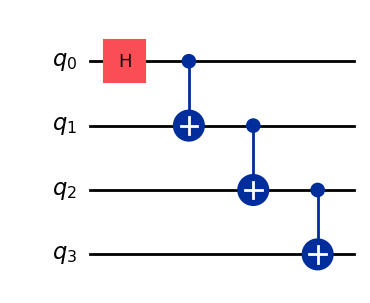

In [5]:
n_qubits = 4
qc_ghz = QuantumCircuit( n_qubits )
qc_ghz.h(0)
for j in range(n_qubits-1):
    qc_ghz.cx(j,j+1)

qc_ghz.draw('mpl')

Si queremos implementar este estado entre los qubits 0, 1, 2, y 3 del dispositivo anterior, vemos que los qubits 2 y 3 no estan conectados, por lo que debemos descomponer la última CNOT en una secuencia de 4 CNOTs:

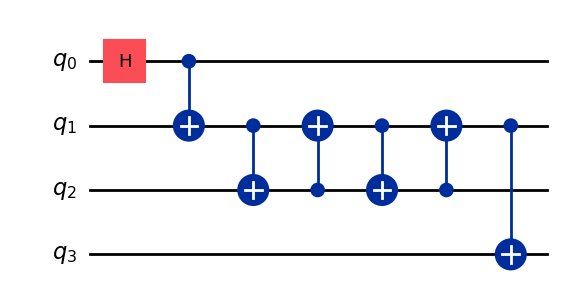

In [6]:
qc_ghz_device = QuantumCircuit( n_qubits )
qc_ghz_device.h(0)
for j in range(n_qubits-2):
    qc_ghz_device.cx(j,j+1)

qc_ghz_device.cx(2,1)
qc_ghz_device.cx(1,2)
qc_ghz_device.cx(2,1)
qc_ghz_device.cx(1,3)

qc_ghz_device.draw('mpl')

Podemos verificar que este circuito implementa correctamente el estado GHZ.

In [7]:
state = Statevector( qc_ghz_device )
state.draw("latex")

<IPython.core.display.Latex object>

Sin embargo, la profundidad de circuit aumento!

In [8]:
qc_ghz_device.depth()

7

Este aumento de profundidad se traduce en que la ejecución de este circuito será de peor calidad, pues hay más puertas cuánticas involucradas. Veamoslo en una simulación considerando un modelo realista del dispositivo.

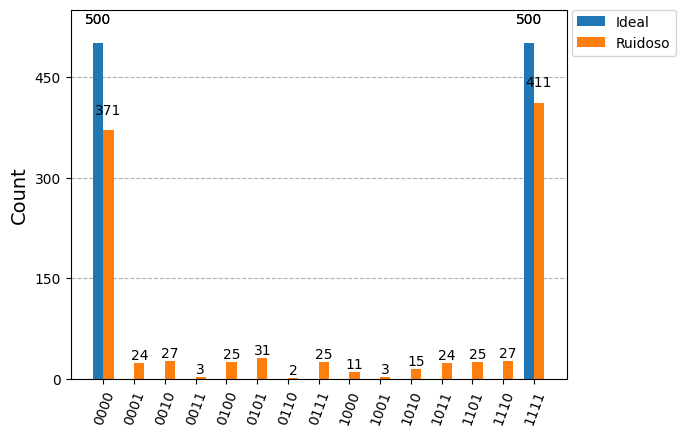

In [9]:
device_backend = FakeDevice()
simulator_noise = AerSimulator.from_backend(device_backend)
qc_ghz_device_measured = qc_ghz_device.copy()
qc_ghz_device_measured.measure_all()
qc_ghz_device_measured =  transpile( qc_ghz_device_measured, device_backend, optimization_level=0 )
counts_device = simulator_noise.run( qc_ghz_device_measured ).result().get_counts()

counts_ideal = { '0000':500, '1111':500  }

plot_histogram( [counts_ideal, counts_device], legend=['Ideal','Ruidoso'] )

__Desafio:__ Construya un circuito cuántico que implemente un estado GHZ de 4 qubits en el dispisitivo cuántico anterior que tenga una profundidad de 4. Escriba su solución en el circuito ``qc_ghz_op``, definido en la siguiente celda.

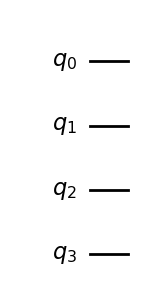

In [10]:
qc_ghz_op = QuantumCircuit( n_qubits )

### escribe tu solución aca ###

###############################

qc_ghz_op.draw('mpl')

Podemos verificar si el circuit funciona mejor que el anterior a través de una simulación con ruido. Como la simulación es un experimento aleatorio, quizás debas ejecutarlo varias veces para convencerte del resultado.

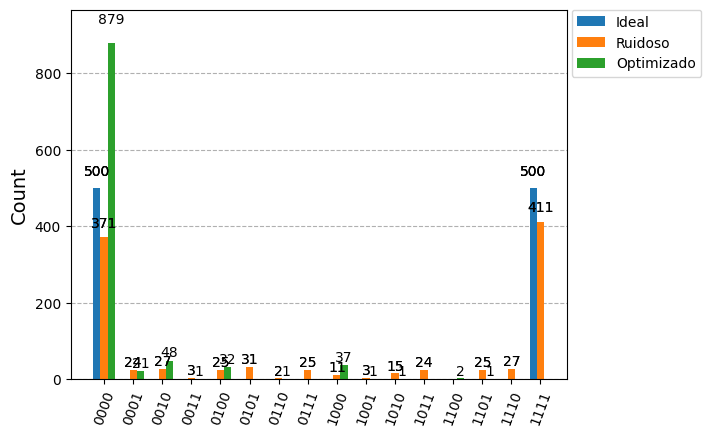

In [11]:
qc_ghz_op_measured = qc_ghz_op.copy()
qc_ghz_op_measured.measure_all()
qc_ghz_op_measured =  transpile( qc_ghz_op_measured, device_backend, optimization_level=0 )
counts_op = simulator_noise.run( qc_ghz_op_measured ).result().get_counts()

plot_histogram( [counts_ideal, counts_device, counts_op], legend=['Ideal','Ruidoso', 'Optimizado']  )

In [12]:
## Esto verifica tu solución, no cambiar!!!! ##
test_2( qc_ghz_op )

El circuito no prepara un estado GHZ
